In [64]:
from qiskit import IBMQ
import sklearn.datasets as skd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.providers.ibmq import least_busy
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from sklearn.datasets import make_blobs
import math

In [2]:
# IBMQ.load_account()

In [3]:
# provider = IBMQ.get_provider(hub='ibm-q-research')
# provider.backends()

In [4]:
X,y = make_blobs(n_samples=70, centers=2, n_features=5, random_state=42)

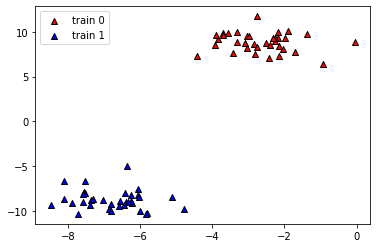

In [5]:
# Data Scatter plot
plt.figure()
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='r', marker='^', edgecolors='k', label="train 0")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='b', marker='^', edgecolors='k', label="train 1")
plt.legend()
plt.show()

In [6]:
sample_train, sample_test, label_train, label_test = train_test_split(X, y, test_size=0.2,  shuffle=True, random_state=42)

# Quantum SVM|VQC - Qiskit

In [7]:
class_labels = [r'B', r'A']#[r'A', r'B']
training_dataset = {key : np.array(sample_train[label_train == k, :])[:] for k, key in enumerate(class_labels)}
test_dataset = {key : np.array(sample_test[label_test == k, :])[:] for k, key in enumerate(class_labels)}

In [8]:
random_seed = 42
feature_dim = 5

In [9]:
# Generate the feature map
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=15)

In [10]:
backend =  BasicAer.get_backend('statevector_simulator')#'statevector_simulator''qasm_simulator'
quantum_instance = QuantumInstance(backend, seed_simulator=random_seed, seed_transpiler=random_seed)

In [11]:
qsvm = QSVM(feature_map = feature_map, training_dataset=training_dataset, test_dataset=test_dataset)

In [12]:
result = qsvm.run(quantum_instance)
# print("testing success ratio: ", result['testing_accuracy'])
print(classification_report(label_test , qsvm.predict(sample_test , quantum_instance)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.62      0.77         8

    accuracy                           0.79        14
   macro avg       0.83      0.81      0.78        14
weighted avg       0.86      0.79      0.78        14



In [17]:
optimizer = SPSA(maxiter=40, c0=4.0, skip_calibration=True)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=7)

In [18]:
vqc= VQC(optimizer = optimizer,feature_map = feature_map,var_form = var_form, training_dataset=training_dataset, test_dataset=test_dataset,)# Variational 

In [19]:
result = vqc.run(quantum_instance)
# print(f'Testing success ratio: {result["testing_accuracy"]}')

In [20]:
print(classification_report(label_test , vqc.predict(sample_test , quantum_instance)[1]))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.62      0.62      0.62         8

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14



# Classic SVM

In [21]:
from sklearn import svm

In [22]:
clf = svm.SVC(gamma='scale')
clf.fit(sample_train, label_train)

SVC()

In [23]:
print(classification_report(label_test, clf.predict(sample_test) , zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



# VQC - Amplitude Encoding Mottonen Method

In [24]:
def get_angles(x, n): # x is an array to be encoded, n is the number of qubits
    numerator = 0 # numerator of expression for beta
    denominator = 0 # denominator of expression for beta
    beta = []
    for k in range (1, n+1): # s is k in Mikko
        for j in range(1, 1+2**(n-k)):
            for l in range(1, 1+2**(k-1)):
                #print("num: k, j, l: ", k, j, l)
                numerator = numerator + (x[((((2*j-1)*(2**(k-1)))+l))-1]**2)
            for l in range(1, 1+2**(k)):
                #print("den: k, j, l: ", k, j, l)
                denominator = denominator + (x[((((j-1)*(2**(k)))+l))-1]**2)
            if k != n:
                beta.append(np.arcsin(np.sqrt(numerator)/np.sqrt(denominator)))
                beta.append(-1*np.arcsin(np.sqrt(numerator)/np.sqrt(denominator)))
            else:
                beta.append(2*np.arcsin(np.sqrt(numerator)/np.sqrt(denominator)))
            numerator = 0
            denominator = 0
    return np.fliplr([beta])[0] # return the last entry in reverse order

In [25]:
def gray_code(n):
    m = n-1 
    xgates = []
    for i in range(1, m):
        xgates_temp = []
        for k in range(1, 2+i):
            xgates_temp.append(n-k-1)
        xgates.append(xgates_temp)
    
    # stagger gates
    num_stag = n-4 # for n=3->0, n=4->0, n=5->1, n=6->2
    #num_gaps = ((2**n)-1)-len(xgates)
    num_gap = len(xgates)-2
    if n>4:
        for j in range(0, num_stag):
            if j==0:
                for i in range(0, num_gap):
                    xgates.insert(j+2+2*i, xgates[j]) #j=0
            else: # j>0 -> 2nd+ staggerization  
                for k in range(0, j):
                    xgates.insert(j+4, xgates[j]) #j=1
                    xgates.insert(j+5, xgates[j-1]) #j=0
    
    # repeat second half
    s = len(xgates)-1
    for i in range(0, s):
        xgates.append(xgates[s-1-i])
        
    return xgates


In [26]:
# create circuit
def amp_enc_qc(A, qc, n):           
    
    # arbitrary transformation of the data (can remove but will need to change hyperparams)
    A = 2*A

    # always apply first rotation
    qc.ry(A[0],0)
                
    #xgates = []
    ang = 1
    for i in range(1, n):
        num_sub_blocks = 2**(i)
        
        # get xgates from gray code
        xgate_idx = 0
        xgates = []
        if i<6:
            xgates = gray_code(i+1)
        elif i>=6:
            if i==6:
                xgates_6 = gray_code(6)
            #xgates_6 = gray_code(6)
            else: 
                xgates_6 = last_xgates
            
            for k in range(0, len(xgates_6)):
                xgates_temp = []
                for j in range(0, len(xgates_6[k])):
                    temp = 1+xgates_6[k][j]
                    xgates_temp.append(temp)
                xgates.append(xgates_temp)
            full_gates = [x for x in range(0, i)]
            xgates.append(full_gates)    
            s = len(xgates)-1
            for k in range(0, s):
                xgates.append(xgates[s-1-k])
            last_xgates = xgates.copy()

        # add initialization gates
        if i>1:
            for k in range(i-1):
                qc.x(k)
                        
        for j in range(1, num_sub_blocks+1):
            for r in range(1, 3):
                if i==1: # if on 2 qubits
                    qc.cx(0, 1)
                elif i==2: # if on 3 qubits
                    qc.ccx(0, 1, 2)
                elif i==3: # if on 4 qubits
                    qc.mcx([0, 1, 2], 3)
                elif i==4:
                    qc.mcx([0, 1, 2, 3], 4) 
                else:
                    q_list = []
                    for k in range(0, i):
                        q_list.append(k)
                    qc.mcx(q_list, i)
   
                qc.ry(A[ang], i)
                ang += 1
                
            #qc.barrier()

            # add x gates
            if (j%2)==1: #if j is odd
                qc.x(i-1)
            else: #j is even
                if ((i>1)&(xgate_idx<len(xgates))):
                    for l in range(0, len(xgates[xgate_idx])):
                        qc.x(xgates[xgate_idx][l])
                        #print('l: ',l)
                    xgate_idx += 1
   
    # account for the extra x-gate discrepancy in the state prep code for 2 qubits
        for l in range(i):
            if i>1:
                qc.x(l)
    if n==2:
        qc.x(0)
    
    return qc

## Parameterized Circuit

In [27]:
# construct variational circuit
def var_classifier(qc, var, n):
    weights = var
    j=1
    for W in weights:
        for i in range(n):
            # parameterized layers
            qc.u3(W[i, 0], W[i, 1], W[i, 2], i)
        if n==2:
            # alternating control nots
            if (j%2)==1:
                qc.cx(0, 1)
            else:
                qc.cx(1, 0)
            j+=1
        elif n>2:
            for i in range(n-1):
                qc.cx(i, i+1)
            qc.cx(0, n-1)
    return qc


In [28]:
# run circuit
def execute_circuit(n, params, angles, x=None, bias=0.0, shots=1000, use_angles=True):
    if not use_angles:
        angles = get_angles(x, n)
        angles = np.nan_to_num(angles)
    
    # create circuit
    q = QuantumRegister(n)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    # Mottonen method
    qc = amp_enc_qc(angles, qc, n)
    
    # divide and conquer
    #qc = _generate_circuit(angles.tolist(), qc, q)

    # parameterized circuit
    qc = var_classifier(qc, params, n)
        
    qc.measure(0, c)
        
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts(qc)
    result = np.zeros(2)
    for key in counts:
        result[int(key, 2)] = counts[key]
    result /= shots
    
    return result[1] + bias

In [29]:
def ctrl_U(param, qc, q, a, ctrl, n):
    order = True # keeps track of alternating cX gates
    for i in range(param.shape[0]): # for each parameterized layer
        for j in range(n):
            # add parameterized gates
            qc.cu3(param[i][j][0], param[i][j][1], param[i][j][2], a[0], q[j], ctrl_state=ctrl)
        if n==2:
            if order:
                qc.ccx(a[0], q[0], q[1]) # add controlled-nots
            else:
                qc.ccx(a[0], q[1], q[0])
            order = not order
        elif n>2:
            for k in range(n-1):
                qc.ccx(a[0], q[k], q[k+1])
            qc.ccx(a[0], q[0], q[n-1])
    return qc
    

In [30]:
def real_inner_prod(n, param1, param2, angles, shots=1000):
    """Returns Re{<circuit(param2)|sigma_z|circuit(param1)>}"""
    a = QuantumRegister(1) # ancilla
    q = QuantumRegister(n)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    # Mottonen method
    qc = amp_enc_qc(angles, qc, n)
    
    # divide and conquer
    #qc = _generate_circuit(angles.tolist(), qc, q)
    
    # add ancilla register
    qc.add_register(a)
    qc.h(a[0])
    
    # (sigma_z)(U)|psi>
    #qc = ctrl_U(param1, qc, q, a, 0) #
    #qc.cz(a[0], q[0], ctrl_state=0) #
    qc = ctrl_U(param1, qc, q, a, 1, n) #
    qc.cz(a[0], q[0], ctrl_state=1) #
    qc.x(a[0]) #
    
    # <psi|(dU)
    qc = ctrl_U(param2, qc, q, a, 1, n)
    
    qc.x(a[0]) #
    
    qc.h(a[0])
    qc.measure(a[0], c)
        
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts(qc)
    result = np.zeros(2)
    for key in counts:
        result[int(key, 2)] = counts[key]
    result /= shots
    return (2*result[0]-1)

In [31]:
def imag_inner_prod(n, param1, param2, angles, shots=1000):
    """Returns Im{<circuit(param2)|sigma_z|circuit(param1)>}"""
    a = QuantumRegister(1) # ancilla
    q = QuantumRegister(n)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
            
    # Mottonen method
    qc = amp_enc_qc(angles, qc, n)
    
    # divide and conquer
    #qc = _generate_circuit(angles.tolist(), qc, q)
    
    # add ancilla register
    qc.add_register(a)
    qc.h(a[0])
        
    # (sigma_z)(U)|psi> #
    #qc = ctrl_U(param1, qc, q, a, 0) #
    #qc.cz(a[0], q[0], ctrl_state=0) #
    qc = ctrl_U(param1, qc, q, a, 1, n) #
    qc.cz(a[0], q[0], ctrl_state=1) #
    qc.x(a[0]) #
    
    # <psi|(dU)
    qc = ctrl_U(param2, qc, q, a, 1, n)
    
    qc.x(a[0]) #
    
    # u1 rotation adds a coefficient of "i" to the second ket (i.e. ancilla qubit=1)
    qc.u1(np.pi/2, a[0])
    qc.h(a[0])
    qc.measure(a[0], c)
        
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts(qc)
    result = np.zeros(2)
    for key in counts:
        result[int(key, 2)] = counts[key]
    result /= shots
    return -(2*result[0]-1)

In [32]:
def gradients(n, params, angles, label, bias=0):
    grads = np.zeros_like(params)
    imag = imag_inner_prod(n, params, params, angles) # needed to calc the imag component of inner product below
    for i in range(params.shape[0]):
        for j in range(params.shape[1]):            
            params_bra = np.copy(params)
                        
            # theta
            params_bra[i,j,0] += np.pi
            grads[i,j,0] = -0.5*real_inner_prod(n, params, params_bra, angles)
            params_bra[i,j,0] -= np.pi # reset for next param below
            
            # phi
            params_bra[i,j,1] += np.pi
            grads[i,j,1] = 0.5*(imag_inner_prod(n, params, params_bra, angles)-imag)
            params_bra[i,j,1] -= np.pi
            
            # lambda
            params_bra[i,j,2] += np.pi
            grads[i,j,2] = 0.5*(imag_inner_prod(n, params, params_bra, angles)-imag)
            params_bra[i,j,2] -= np.pi
            
    p = execute_circuit(n, params, angles, bias=bias) 
    grad_bias = (p-label) / (p*(1-p))
    grads *= grad_bias
    return grads, grad_bias

In [33]:
def train_model(n, layers, params_init, bias_init, batch_size, learning_rate, momentum, iterations, feats_train, Y_train, feats_val, Y_val, features, Y):
    var = np.copy(params_init)
    bias = bias_init
    v = np.zeros_like(var)
    v_bias = 0
    
    num_train = len(feats_train)
    
    for it in range(iterations):
        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        grads = np.zeros_like(var)
        grad_bias = 0
        var_corrected = var + momentum*v
        bias_corrected = bias + momentum*v_bias
        for j in range(batch_size):
            g, g_bias = gradients(n, var_corrected, feats_train_batch[j], Y_train_batch[j], bias)
            grads += g/batch_size
            grad_bias += g_bias/batch_size

        v = momentum*v - learning_rate*grads
        v_bias = momentum*v_bias - learning_rate*grad_bias

        var += v
        bias += v_bias

        # Compute predictions on train and validation set
        prob_train = np.array([execute_circuit(n, var, angles=f, bias=bias) for f in feats_train])
        prob_val = np.array([execute_circuit(n, var, angles=f, bias=bias) for f in feats_val])
        pred_train = predict(prob_train)
        pred_val = predict(prob_val)

        # Compute accuracy on train and validation set
        acc_train = accuracy(Y_train, pred_train)
        acc_val = accuracy(Y_val, pred_val)

        print("Iter: {:5d} | Loss: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
              "".format(it + 1, cost(n, var, features, Y), acc_train, acc_val))
    
    return var, bias

### Performance metrics

In [34]:
def predict(prob):
    return (prob >= 0.5)*1

def binary_crossentropy(labels, pred):
    loss = 0
    for l, p in zip(labels, pred):
        loss = loss - l*np.log(np.max([p, 1e-8]))
    loss = loss/len(labels)
    return loss

def square_loss(labels, pred):
    loss = 0
    for l, p in zip(labels, pred):
        loss = loss + (l-p)**2
    loss = loss/len(labels)
    return loss 

def cost(n, params, features, labels):
    pred = [execute_circuit(n, params, angles=f) for f in features]
    return binary_crossentropy(labels, pred)

def accuracy(labels, pred):
    loss = 0
    for l, p in zip(labels, pred):
        if abs(l-p) < 1e-5:
            loss = loss+1
    loss = loss/len(labels)
    return loss

# Training the model

In [80]:
def nextPowerOf2(n):
    p = 1
    if (n and not(n & (n - 1))):
        return n
    while (p < n) :
        p <<= 1     
    return p;

In [108]:
nextPowerOf2(len(X[0]))

8

In [105]:
padding_X = 0.3 * np.ones((len(X), np.zeros((nextPowerOf2(len(X[0])),1))-len(X[0])))

TypeError: only integer scalar arrays can be converted to a scalar index

In [115]:
# padding_X = np.zeros((nextPowerOf2(len(X[0])),1))
padding_X = 0.3*np.ones((len(X), nextPowerOf2(len(X[0]))-len(X[0])))

X_pad = np.c_[np.c_[X, padding_X], np.zeros((len(X), 0))]
X_pad
print("First X sample (original)  :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X**2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

First X sample (original)  : [-7.38705277 -9.30936606  7.55557285  0.57421589  2.75398778  0.3
  0.3         0.3       ]
First X sample (normalized): [-0.51438866 -0.64824667  0.52612336  0.03998484  0.19177067  0.02089014
  0.02089014  0.02089014]


In [116]:
# number of qubits
n = 3
num_qubits = n # needed for D&C

# angles for state preparation are new features; impute nans
features = np.array([get_angles(x, n) for x in X_norm])
features = np.nan_to_num(features)

# divide and conquer
#features = np.array([recursive_compute_beta(x, betas=[]) for x in X_norm])

In [117]:
# set random seed
np.random.seed(0)

# number of samples
num_data = len(y) # 100

# number of training samples
num_train = int(0.75*num_data) # 75

# randomly split into train, validation sets
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [123]:
# number of parameterized layers
layers = 2 #1
batch_size = 10
iterations = 6

# initial parameters
params_init = np.random.randn(layers, n, 3)*0.01
bias_init = 0.01
learning_rate = 0.01
momentum = 0.9

# set backend to run 
backend = BasicAer.get_backend('qasm_simulator')

# train model
var, bias = train_model(n, layers, params_init, bias_init, batch_size, learning_rate, momentum, iterations, feats_train, Y_train, feats_val, Y_val, features, y)

Iter:     1 | Loss: 0.5957759 | Acc train: 0.0769231 | Acc validation: 0.0555556 
Iter:     2 | Loss: 0.6169725 | Acc train: 0.2307692 | Acc validation: 0.0555556 
Iter:     3 | Loss: 0.6281000 | Acc train: 0.5384615 | Acc validation: 0.3888889 
Iter:     4 | Loss: 0.6614992 | Acc train: 0.5384615 | Acc validation: 0.3888889 
Iter:     5 | Loss: 0.6740265 | Acc train: 0.5384615 | Acc validation: 0.3888889 
Iter:     6 | Loss: 0.7033934 | Acc train: 0.5384615 | Acc validation: 0.3888889 
